In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import skimage
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import scipy
import PIL
from PIL import Image

In [31]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Final')

Mounted at /content/drive/


In [32]:
def config_plot():
    """
    Helper function
    Remove axis tickers and box around figure
    """
    plt.box(False)
    plt.axis('off')

In [33]:
def gaussian_kernel(kernel_size, sigma):
    x = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    gaussian_1d = np.exp(-x**2 / (2 * sigma**2))
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    return gaussian_2d / np.sum(gaussian_2d)

In [34]:
def sharpen_kernel(kernel_size, ver):
    if kernel_size == 3:
        if ver == 1:
            sharpen = np.array([
                [0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]
            ])
        if ver == 2:
            sharpen = np.array([
                [-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]
            ])
    if kernel_size == 5:
        if ver == 1:
            sharpen = np.array([
                [0, 0, -1, 0, 0],
                [0, -1, -1, -1, 0],
                [-1, -1, 13, -1, -1],
                [0, -1, -1, -1, 0],
                [0, 0, -1, 0, 0]
            ])
        if ver == 2:
            sharpen = np.array([
                [-1, -1, -1, -1, -1],
                [-1, -1, -1, -1, -1],
                [-1, -1, 25, -1, -1],
                [-1, -1, -1, -1, -1],
                [-1, -1, -1, -1, -1]
            ])
    return sharpen

In [35]:
def conv_gaussian(image, kernel_size, sigma):
    image_shape = image.shape
    image_gaussian = np.zeros(image_shape)
    for i in range(image_shape[-1]):
        image_gaussian[:, :, i] = scipy.ndimage.convolve(image[:, :, i], gaussian_kernel(kernel_size=kernel_size, sigma=sigma), output=np.float32)
    return image_gaussian

In [36]:
def conv_sharpen(image, kernel_size, ver):
    image_shape = image.shape
    image_sharpen = np.zeros(image_shape, dtype=np.float32)
    for i in range(image_shape[-1]):
        image_sharpen[:, :, i] = scipy.ndimage.convolve(image[:, :, i], sharpen_kernel(kernel_size=kernel_size, ver=ver), output=np.float32)
    image_sharpen = np.clip(image_sharpen, 0, 1)
    return image_sharpen

In [37]:
image_r = Image.open("src/data/Winter_Garden_0-1-Webcam-R-000.png")
image_c = Image.open("src/data/Winter_Garden_0-1-Webcam-C-000.png")

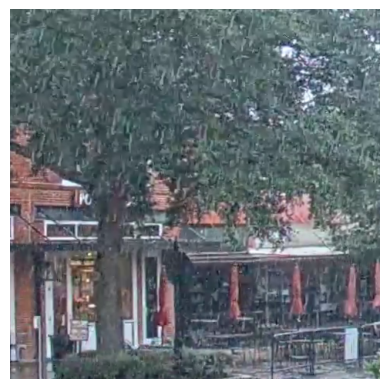

In [38]:
plt.figure()
plt.imshow(image_r)
config_plot()
plt.show()

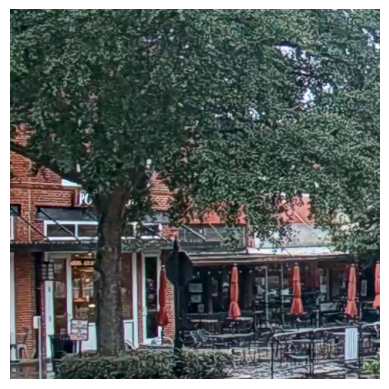

In [39]:
plt.figure()
plt.imshow(image_c)
config_plot()
plt.show()

In [40]:
print(image_r.size)

(480, 480)


In [41]:
image_r_np = np.asarray(image_r, dtype=np.float32) / 255
# image_r_np = image_r_np.transpose(2, 0, 1)
print(image_r_np.shape)
print(np.max(image_r_np))
image_c_np = np.asarray(image_c, dtype=np.float32) / 255
# image_c_np = image_c_np.transpose(2, 0, 1)
print(image_c_np.shape)
print(np.max(image_c_np))

image_shape = image_r_np.shape
image_shape

(480, 480, 3)
1.0
(480, 480, 3)
1.0


(480, 480, 3)

In [42]:
image_r_gaussian = conv_gaussian(image_r_np, kernel_size=7, sigma=1)

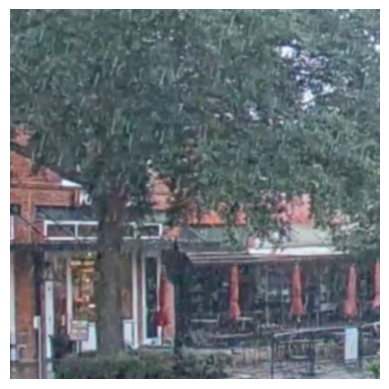

In [43]:
plt.figure()
plt.imshow(image_r_gaussian)
config_plot()
plt.show()

In [44]:
image_r_sharpen = conv_sharpen(image_r_gaussian, kernel_size=3, ver=1)

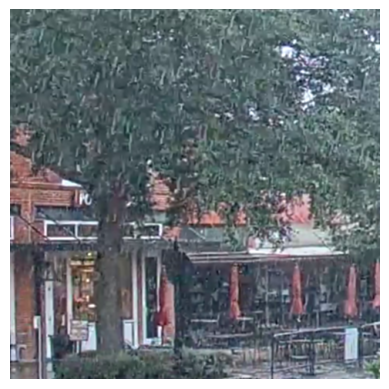

In [45]:
plt.figure()
plt.imshow(image_r_sharpen)
config_plot()
plt.show()

In [46]:
print(f"input psnr: {psnr(image_r_np, image_c_np)}")
print(f"output psnr: {psnr(image_r_sharpen, image_c_np)}")
print(f"input ssim: {ssim(image_r_np, image_c_np, channel_axis=2)}")
print(f"output ssim: {ssim(image_r_sharpen, image_c_np, channel_axis=2)}")

input psnr: 17.101633311875094
output psnr: 17.110933482400792
input ssim: 0.5913126468658447
output ssim: 0.6002528667449951


In [47]:
import os
from natsort import natsorted
from glob import glob
from tqdm import tqdm

In [48]:
derain_data_path = "src/data/GT-RAIN_test/"
folders = ["Gurutto_0-0", "M1135_0-0", "Oinari_0-0", "Oinari_1-1", "Table_Rock_0-0", "Winter_Garden_0-1", "Winter_Garden_0-4"]
avg_psnr_in = []
avg_psnr_out = []
avg_ssim_in = []
avg_ssim_out = []

# gaussian_kernel_size = 5
# gaussian_kernel_sigma = 1
# sharpen_kernel_size = 3
# sharpen_kernel_ver = 1

gaussian_kernel_size = 7
gaussian_kernel_sigma = 1
sharpen_kernel_size = 3
sharpen_kernel_ver = 1

print("Parameters:")
print(f"Gaussian Kernel: Size {gaussian_kernel_size}, Sigma {gaussian_kernel_sigma}")
print(f"Sharpen Kernel: Size {sharpen_kernel_size}, Ver {sharpen_kernel_ver}")

for folder in folders:
    total_psnr_in = 0
    total_psnr_out = 0
    total_ssim_in = 0
    total_ssim_out = 0
    total_image_r_count = 0

    images_path = derain_data_path + folder
    clean_image_path = glob(images_path + "/*C-000.png")[0]
    rainy_image_paths = natsorted(glob(images_path + "/*R-*.png"))

    image_c = Image.open(clean_image_path)
    image_c_np = np.array(image_c, dtype=np.float32) / 255
    for i in tqdm(range(len(rainy_image_paths))):
        image_r = Image.open(rainy_image_paths[i])
        image_r_np = np.array(image_r, dtype=np.float32) / 255
        image_r_sharpen = conv_sharpen(conv_gaussian(image_r_np, gaussian_kernel_size, gaussian_kernel_sigma), sharpen_kernel_size, sharpen_kernel_ver)
        total_psnr_in += psnr(image_r_np, image_c_np)
        total_psnr_out += psnr(image_r_sharpen, image_c_np)
        total_ssim_in += ssim(image_r_np, image_c_np, channel_axis=2)
        total_ssim_out += ssim(image_r_sharpen, image_c_np, channel_axis=2)
        total_image_r_count += 1
    print(f"Folder: {folder}")
    print(f"Average PSNR in: {total_psnr_in / total_image_r_count}")
    print(f"Average PSNR out: {total_psnr_out / total_image_r_count}")
    print(f"Average SSIM in: {total_ssim_in / total_image_r_count}")
    print(f"Average SSIM out: {total_ssim_out / total_image_r_count}")


Parameters:
Gaussian Kernel: Size 7, Sigma 1
Sharpen Kernel: Size 3, Ver 1


100%|██████████| 300/300 [00:13<00:00, 22.50it/s]


Folder: Gurutto_0-0
Average PSNR in: 23.60950793884464
Average PSNR out: 23.640127908559606
Average SSIM in: 0.8380727716286978
Average SSIM out: 0.8457206080357234


100%|██████████| 300/300 [00:10<00:00, 29.70it/s]


Folder: M1135_0-0
Average PSNR in: 20.057576238092683
Average PSNR out: 20.069679762918287
Average SSIM in: 0.7491096035639445
Average SSIM out: 0.7499410059054693


100%|██████████| 300/300 [00:02<00:00, 108.30it/s]


Folder: Oinari_0-0
Average PSNR in: 19.96470942644114
Average PSNR out: 19.972942553905018
Average SSIM in: 0.6833024768034617
Average SSIM out: 0.7015342402458191


100%|██████████| 300/300 [00:12<00:00, 23.97it/s]


Folder: Oinari_1-1
Average PSNR in: 16.34053245417025
Average PSNR out: 16.37330956652389
Average SSIM in: 0.5764776136477788
Average SSIM out: 0.585482872525851


100%|██████████| 300/300 [00:12<00:00, 23.30it/s]


Folder: Table_Rock_0-0
Average PSNR in: 22.5996359923275
Average PSNR out: 22.669464389750825
Average SSIM in: 0.879292424718539
Average SSIM out: 0.8868106327454249


100%|██████████| 300/300 [00:35<00:00,  8.37it/s]


Folder: Winter_Garden_0-1
Average PSNR in: 16.995620733007314
Average PSNR out: 16.989797627939343
Average SSIM in: 0.5754280887047449
Average SSIM out: 0.5832650246222814


100%|██████████| 300/300 [00:14<00:00, 21.15it/s]

Folder: Winter_Garden_0-4
Average PSNR in: 16.896366024180825
Average PSNR out: 16.911153037168578
Average SSIM in: 0.523487984140714
Average SSIM out: 0.5320449103911717


In [55]:
dehaze_data_path = "src/data/RESIDE-OUT/test/"
image_c_folder = "GT"
image_h_folder = "hazy"

avg_psnr_in = []
avg_psnr_out = []
avg_ssim_in = []
avg_ssim_out = []

sharpen_kernel_size = 3
sharpen_kernel_ver = 1

print("Parameters:")
print(f"Sharpen Kernel: Size {sharpen_kernel_size}, Ver {sharpen_kernel_ver}")

image_c_paths = natsorted(glob(dehaze_data_path + image_h_folder + "/*.jpg"))
image_h_paths = natsorted(glob(dehaze_data_path + image_c_folder + "/*.jpg"))

total_psnr_in = 0
total_psnr_out = 0
total_ssim_in = 0
total_ssim_out = 0
total_image_h_count = 0

for image_c_path, image_h_path in tqdm(list(zip(image_c_paths, image_h_paths))):
    image_c = Image.open(image_c_path)
    image_c_np = np.array(image_c, dtype=np.float32) / 255
    image_h = Image.open(image_h_path)
    image_h_np = np.array(image_h, dtype=np.float32) / 255
    image_h_sharpen = conv_sharpen(image_h_np, sharpen_kernel_size, sharpen_kernel_ver)
    total_psnr_in += psnr(image_h_np, image_c_np)
    total_psnr_out += psnr(image_h_sharpen, image_c_np)
    total_ssim_in += ssim(image_h_np, image_c_np, channel_axis=2)
    total_ssim_out += ssim(image_h_sharpen, image_c_np, channel_axis=2)
    total_image_h_count += 1

print(f"Average PSNR in: {total_psnr_in / total_image_h_count}")
print(f"Average PSNR out: {total_psnr_out / total_image_h_count}")
print(f"Average SSIM in: {total_ssim_in / total_image_h_count}")
print(f"Average SSIM out: {total_ssim_out / total_image_h_count}")

Parameters:
Sharpen Kernel: Size 3, Ver 1


100%|██████████| 500/500 [00:47<00:00, 10.49it/s]

Average PSNR in: 15.936805460852966
Average PSNR out: 14.630270428485378
Average SSIM in: 0.8252594929933548
Average SSIM out: 0.6381764367222786
